In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import MinMaxScaler
from scipy import sparse
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import cross_val_score,ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier           
from sklearn import metrics    
from lightgbm import LGBMClassifier

In [2]:
df = pd.read_csv('./data/lab3-data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42176 entries, 0 to 42175
Columns: 487 entries, Unnamed: 0 to SOCONPA
dtypes: float64(471), int64(14), object(2)
memory usage: 156.7+ MB


In [4]:
df.isnull().sum()

Unnamed: 0        0
index             0
CNTRYID           0
CNT               0
NatCen            0
              ...  
ATTIMMP       27129
INTCULTP      27190
GCAWAREP      26863
BODYIMA       10832
SOCONPA        9660
Length: 487, dtype: int64

In [5]:
df.head()

,Unnamed: 0,index,CNTRYID,CNT,NatCen,STRATUM,SUBNATIO,OECD,ADMINMODE,LANGTEST_COG,...,EMOSUPP,PQSCHOOL,PASCHPOL,PRESUPP,JOYREADP,ATTIMMP,INTCULTP,GCAWAREP,BODYIMA,SOCONPA
0,0,11956,152.0,CHL,15200,CHL0206,1520000,1.0,2.0,156.0,...,0.739,0.7457,1.6215,-0.5678,-1.5853,-0.9700,-0.7128,-0.4661,NaN,NaN
1,1,11958,152.0,CHL,15200,CHL0414,1520000,1.0,2.0,156.0,...,0.739,2.0484,1.3268,-0.2262,0.0327,-0.4189,-0.0831,0.2619,NaN,NaN
2,2,11960,152.0,CHL,15200,CHL0308,1520000,1.0,2.0,156.0,...,0.739,-0.7951,-0.6368,0.6406,0.8279,-2.1628,0.6497,-0.6305,NaN,NaN
3,3,11961,152.0,CHL,15200,CHL0414,1520000,1.0,2.0,156.0,...,0.739,-1.4552,-1.1177,-1.1910,1.3690,-1.5354,-0.3192,-0.4310,NaN,NaN
4,4,11965,152.0,CHL,15200,CHL0308,1520000,1.0,2.0,156.0,...,0.739,0.3731,0.5620,0.5225,-0.4457,-0.4189,0.7827,-1.7909,NaN,NaN


In [6]:
def drop_col(df, cutoff=0.9): 
    n = len(df)
    cnt = df.count() 
    cnt = cnt / n 
    return df.loc[:, cnt[cnt >= cutoff].index] 
df = drop_col(df)

In [7]:
print(df.isnull().sum())

Unnamed: 0       0
index            0
CNTRYID          0
CNT              0
NatCen           0
              ... 
SWBP          4032
RESILIENCE    4127
ENTUSE        2041
ICTCLASS      1131
ICTOUTSIDE    1830
Length: 179, dtype: int64


In [8]:
# CNTRYID与CNT,NatCen意义重复，故删除CNT,NatCen。STRATUM,SUBNATIO的地域信息更为详细，但数据过于复杂，故删去
df = df.drop(columns = ['CNT','NatCen','STRATUM','SUBNATIO'])

In [9]:
# 实验任务为分析其他特征与REPEAT的关系，故删去REPEAT特征缺失的样本
df = df.dropna(subset = 'REPEAT')
# 删去与实验无关的列Unamed:0
df = df.drop(columns = ['Unnamed: 0','index','ADMINMODE','LANGTEST_COG'])

In [10]:
cols = df.columns
for col in cols:
    if df[col].var() == 0:
        print(col+' : '+ str(df[col].dtype))

In [11]:
cols = df.columns
for col in cols:
    print(col+' : '+ str(df[col].dtype))

CNTRYID : float64
OECD : float64
BOOKID : float64
ST001D01T : float64
ST003D02T : float64
ST003D03T : float64
ST004D01T : float64
ST005Q01TA : float64
ST006Q02TA : float64
ST007Q01TA : float64
ST011Q01TA : float64
ST011Q02TA : float64
ST011Q03TA : float64
ST011Q04TA : float64
ST011Q05TA : float64
ST011Q06TA : float64
ST011Q07TA : float64
ST011Q08TA : float64
ST011Q09TA : float64
ST011Q10TA : float64
ST011Q11TA : float64
ST011Q12TA : float64
ST011Q16NA : float64
ST011D17TA : int64
ST011D18TA : int64
ST011D19TA : int64
ST012Q01TA : float64
ST012Q02TA : float64
ST012Q03TA : float64
ST012Q05NA : float64
ST012Q06NA : float64
ST012Q07NA : float64
ST012Q08NA : float64
ST012Q09NA : float64
ST013Q01TA : float64
ST019AQ01T : float64
ST019BQ01T : float64
ST019CQ01T : float64
ST125Q01NA : float64
ST126Q01TA : float64
ST127Q01TA : float64
ST127Q02TA : float64
ST022Q01TA : float64
ST023Q01TA : float64
ST023Q02TA : float64
ST023Q03TA : float64
ST023Q04TA : float64
ST023Q05TA : float64
ST097Q01TA : fl

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42102 entries, 0 to 42175
Columns: 171 entries, CNTRYID to ICTOUTSIDE
dtypes: float64(161), int64(10)
memory usage: 55.2 MB


In [13]:
df.describe()

,CNTRYID,OECD,BOOKID,ST001D01T,ST003D02T,ST003D03T,ST004D01T,ST005Q01TA,ST006Q02TA,ST007Q01TA,...,ATTLNACT,COMPETE,WORKMAST,GFOFAIL,EUDMO,SWBP,RESILIENCE,ENTUSE,ICTCLASS,ICTOUTSIDE
count,42102.000000,42102.000000,42102.000000,42102.000000,42102.000000,42102.000000,42102.000000,41175.000000,38469.000000,40432.000000,...,39801.000000,39316.000000,38818.000000,38828.000000,38437.000000,38103.000000,38012.000000,40072.000000,40982.000000,40284.000000
mean,598.141941,0.889103,22.384922,9.748017,6.592846,2002.072324,1.492708,2.005027,1.627778,2.141695,...,0.207934,0.094364,0.271971,-0.040741,0.202601,0.298496,0.261772,-0.029140,-0.159516,0.036089
std,196.763039,0.314009,17.024751,0.557680,3.447780,0.259027,0.499953,1.137315,0.483403,1.163633,...,1.024722,0.993216,0.984266,0.972472,1.000609,0.935085,1.019363,0.962934,0.980001,0.998441
min,152.000000,0.000000,1.000000,7.000000,1.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,...,-2.537500,-2.345000,-2.736500,-1.893900,-2.146400,-3.066600,-3.167500,-3.594000,-1.218800,-1.304800
25%,484.000000,1.000000,9.000000,10.000000,4.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,...,-0.658300,-0.570700,-0.454000,-0.687000,-0.523000,-0.592800,-0.468400,-0.442625,-1.218800,-0.723300
50%,724.000000,1.000000,18.000000,10.000000,7.000000,2002.000000,1.000000,2.000000,2.000000,2.000000,...,0.462600,0.195600,0.211900,-0.084500,0.262100,0.501200,-0.048500,-0.065350,-0.179900,0.079900
75%,724.000000,1.000000,37.000000,10.000000,10.000000,2002.000000,2.000000,3.000000,2.000000,3.000000,...,1.084400,0.787100,0.880600,0.463700,0.926900,1.238600,0.823600,0.365600,0.514700,0.617400
max,724.000000,1.000000,72.000000,12.000000,12.000000,2003.000000,2.000000,5.000000,2.000000,5.000000,...,1.084400,2.005400,1.816400,1.890500,1.741100,1.238600,2.369300,4.248300,2.439400,2.496900


In [14]:
df = df.fillna(df.mean())

In [15]:
print(df.isnull().sum())

CNTRYID       0
OECD          0
BOOKID        0
ST001D01T     0
ST003D02T     0
             ..
SWBP          0
RESILIENCE    0
ENTUSE        0
ICTCLASS      0
ICTOUTSIDE    0
Length: 171, dtype: int64


In [16]:
data = df.loc[:,:]
data = data.drop(columns = 'REPEAT')
labels = df.loc[:,'REPEAT']
names = data.columns
#train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.1)
#len(test_data)
labels = labels.astype('int')

In [17]:
model = XGBClassifier(learning_rate = 0.1,
                            booster = 'gbtree',
                            max_depth = 20,
                            gamma = 2,
                            subsample = 1,
                            objective = 'binary:logitraw',
                            eval_metric = 'mlogloss',)
model.fit(data, labels)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=2, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='binary:logitraw',
              predictor=None, ...)

In [18]:
print(cross_val_score(model, data, labels,scoring='accuracy', cv=10).mean())

0.9968177790212378


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


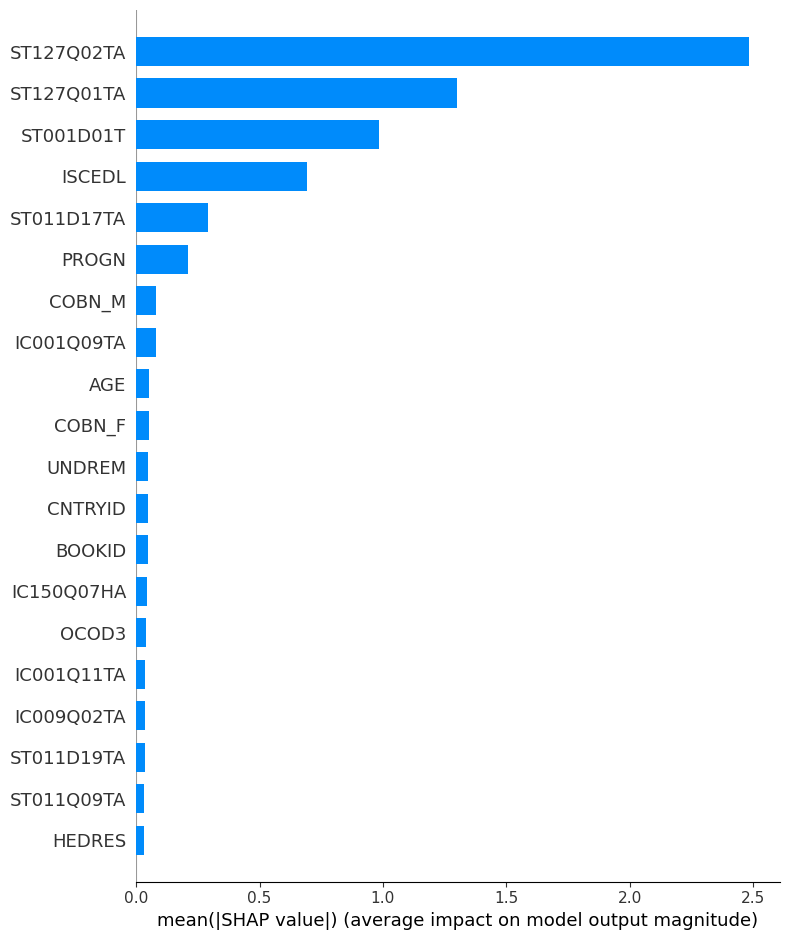

In [19]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(data)
shap.summary_plot(shap_values, data, plot_type="bar")

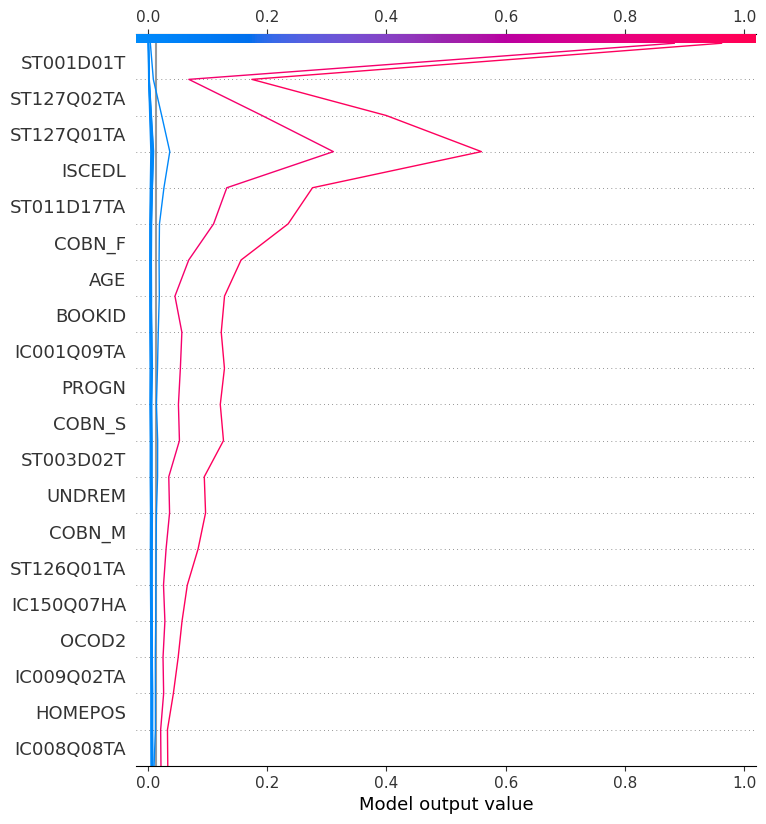

In [20]:
expected_value = explainer.expected_value
features = data.iloc[range(20)]
shap_values2 = explainer.shap_values(data)[1:10]

shap.decision_plot(expected_value, shap_values2, 
                   data.columns,link='logit')

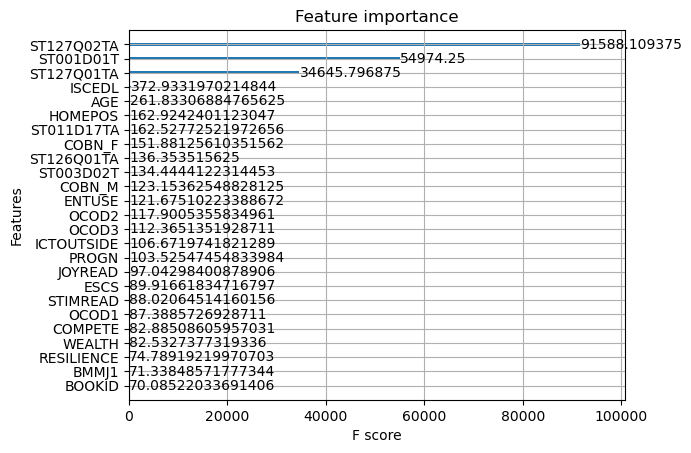

In [21]:
plot_importance(model,  height=0.2,xlim=None, ylim=None, 
				title='Feature importance',xlabel='F score', 
				ylabel='Features',importance_type='total_gain', 
				max_num_features=25,grid=True, show_values=True)

plt.show()

In [22]:
data_new = data.loc[:,['ST127Q02TA','ST127Q01TA','ST001D01T','ISCEDL','AGE','HOMEPOS','ST011D17TA','COBN_F','ENTUSE']]

In [23]:
data_new.describe()

,ST127Q02TA,ST127Q01TA,ST001D01T,ISCEDL,AGE,HOMEPOS,ST011D17TA,COBN_F,ENTUSE
count,42102.000000,42102.000000,42102.000000,42102.000000,42102.000000,42102.000000,4.210200e+04,42102.000000,42102.000000
mean,1.154675,1.097816,9.748017,2.337751,15.829446,-0.364773,7.003877e+05,163974.450335,-0.029140
std,0.383473,0.308881,0.557680,0.472949,0.286295,1.168049,9.948421e+05,292444.079724,0.939432
min,1.000000,1.000000,7.000000,2.000000,15.250000,-8.942500,1.520010e+05,15200.000000,-3.594000
25%,1.000000,1.000000,10.000000,2.000000,15.580000,-1.019250,4.840020e+05,48400.000000,-0.418275
50%,1.000000,1.000000,10.000000,2.000000,15.830000,-0.269300,7.240010e+05,72406.000000,-0.029140
75%,1.000000,1.000000,10.000000,3.000000,16.080000,0.375800,7.240010e+05,72413.000000,0.338775
max,3.000000,3.000000,12.000000,3.000000,16.330000,5.429700,9.999999e+06,999999.000000,4.248300


In [24]:
def draw_corr_map(df,method='pearson'):
    df = pd.concat([df, labels], axis=1)
    map = df.corr(method=method)
    sns.heatmap(map, annot=True, cmap='coolwarm')
    return map

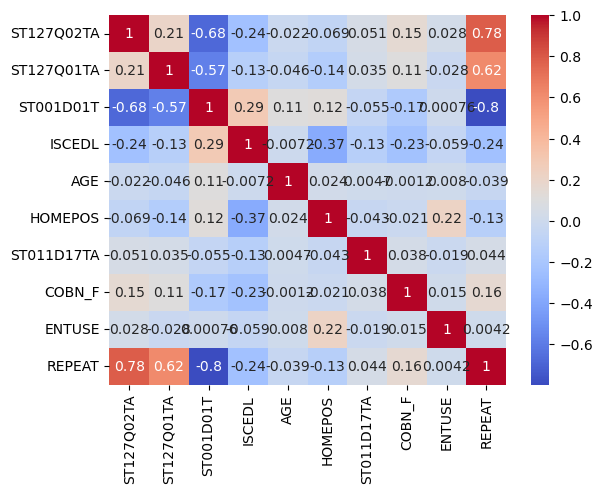

In [25]:
map = draw_corr_map(data_new)

In [26]:
model2 = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.03,
    num_leaves=30,
    colsample_bytree=.8,
    subsample=.9,
    max_depth=7,
    reg_alpha=.1,
    reg_lambda=.1,
    min_split_gain=.01,
    min_child_weight=2,
    verbose=-1,
)

model2.fit(data, labels)


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.03, max_depth=7,
               min_child_weight=2, min_split_gain=0.01, n_estimators=400,
               num_leaves=30, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9,
               verbose=-1)

In [27]:
print(cross_val_score(model2, data, labels,scoring='accuracy', cv=10).mean())

0.9967227897075356


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


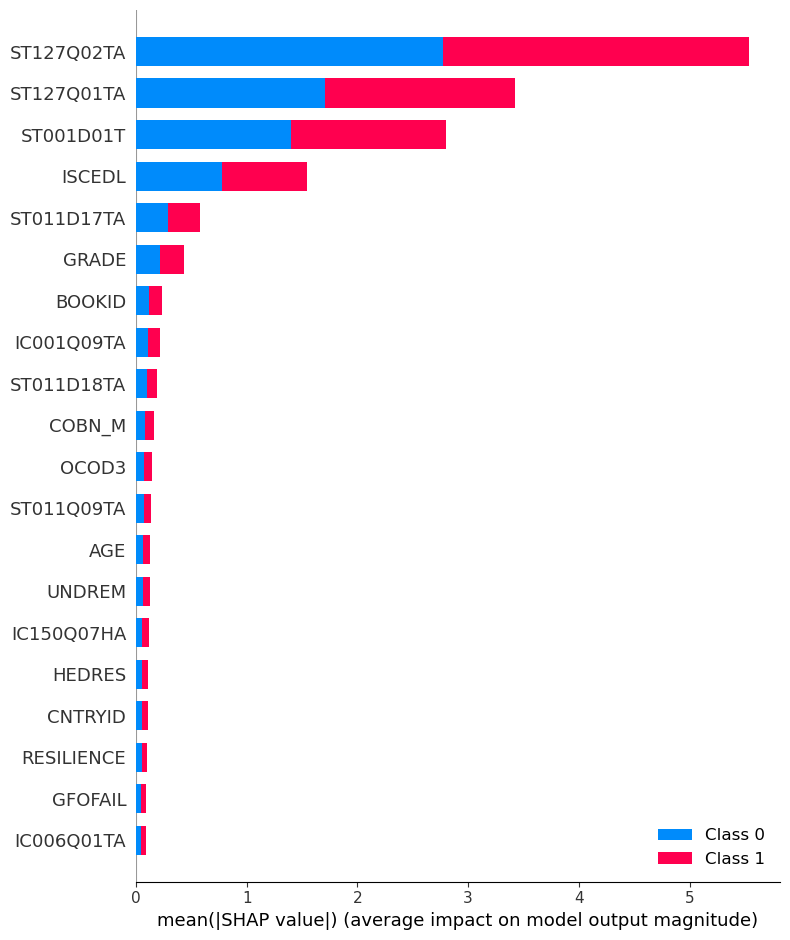

In [28]:
explainer2 = shap.Explainer(model2)
shap_values21 = explainer2.shap_values(data)
shap.summary_plot(shap_values21, data, plot_type="bar")

Explainer expected value: -4.258357524871826


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


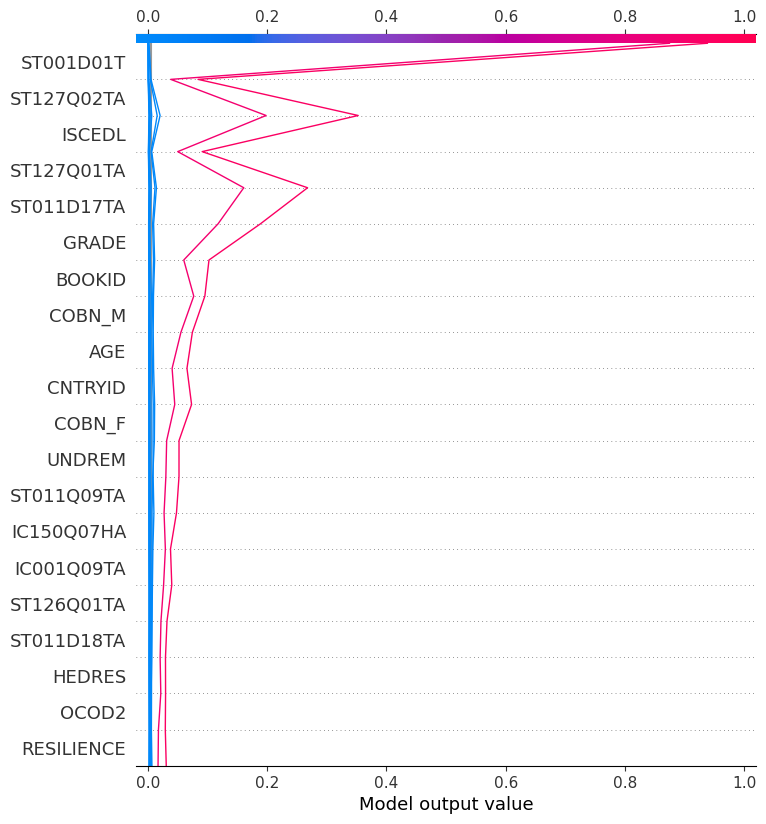

In [29]:
expected_value2 = explainer2.expected_value
features = data.iloc[range(20)]
if isinstance(expected_value2, list):
    expected_value3 = expected_value2[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = data.iloc[select]
features_display = data.loc[features.index]
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values22 = explainer2.shap_values(features)[1]
    shap_interaction_values = explainer2.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
shap_values22 = explainer2.shap_values(data)[1]

shap.decision_plot(expected_value2[1], shap_values22[1:10], 
                   data.columns,link='logit')



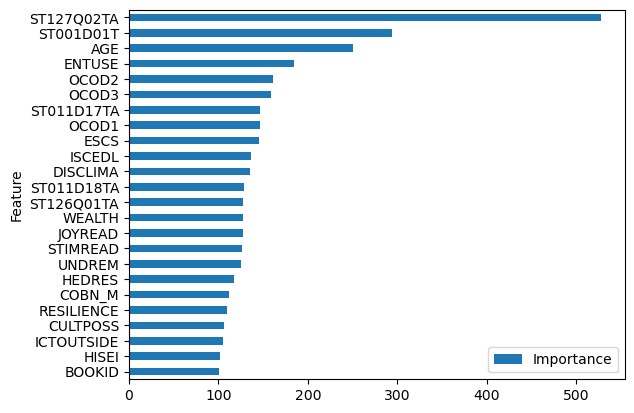

In [30]:
importance_frame = pd.DataFrame({'Importance': list(model2.feature_importances_), 'Feature': data.columns})
importance_frame.sort_values(by='Importance',inplace=True)

importance_frame[-25:-1].plot(kind='barh', x='Feature')
plt.show()


In [31]:
data_new2 = data.loc[:,['ST127Q02TA','ST127Q01TA','ST001D01T','ISCEDL','GRADE','BOOKID','AGE','OCOD2','ENTUSE']]

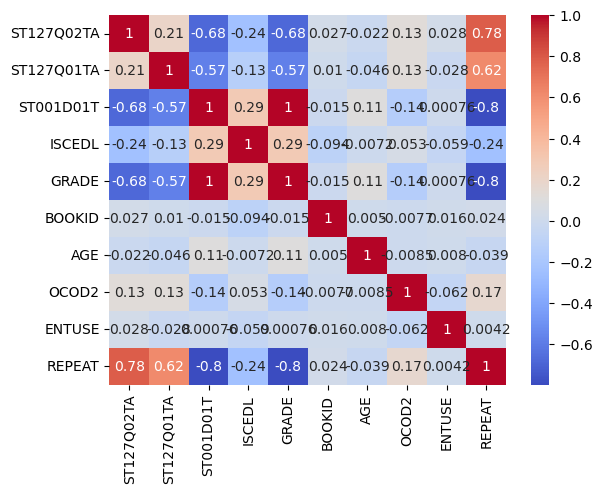

In [32]:
map = draw_corr_map(data_new2)

In [33]:
model3 = DecisionTreeClassifier(criterion='gini', max_depth=150)

model3.fit(data, labels)


DecisionTreeClassifier(max_depth=150)

In [34]:
print(cross_val_score(model3, data, labels,scoring='accuracy', cv=10).mean())

0.9898822391982088


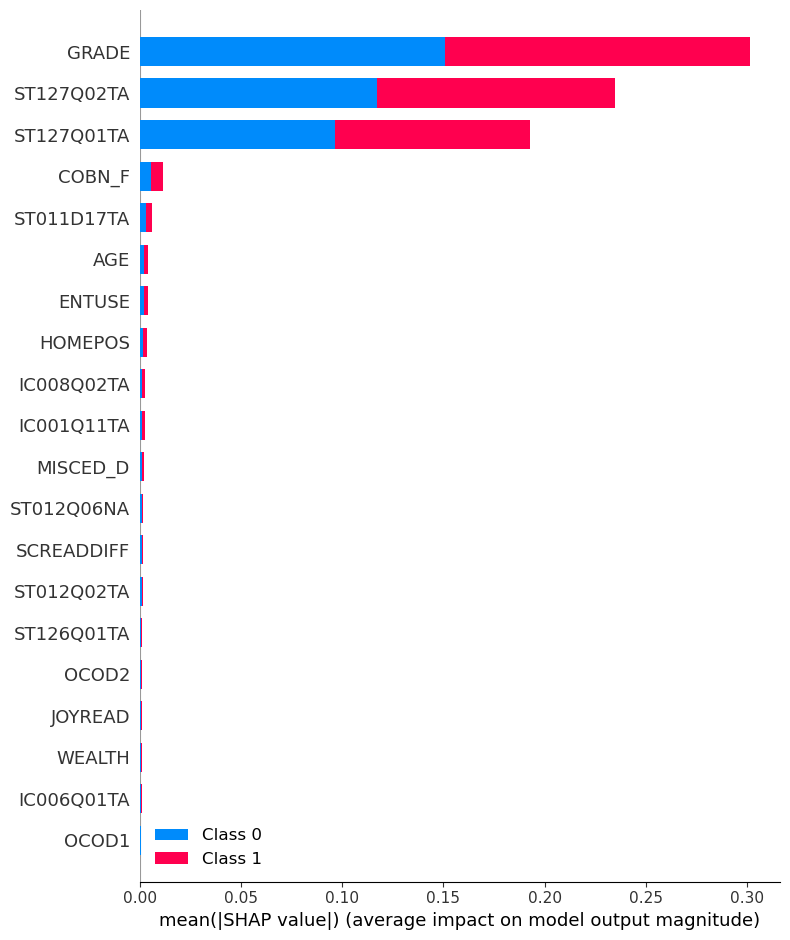

In [35]:
explainer3 = shap.Explainer(model3)
shap_values31 = explainer3.shap_values(data)
shap.summary_plot(shap_values31, data, plot_type="bar")

Explainer expected value: [0.79338274 0.20661726]


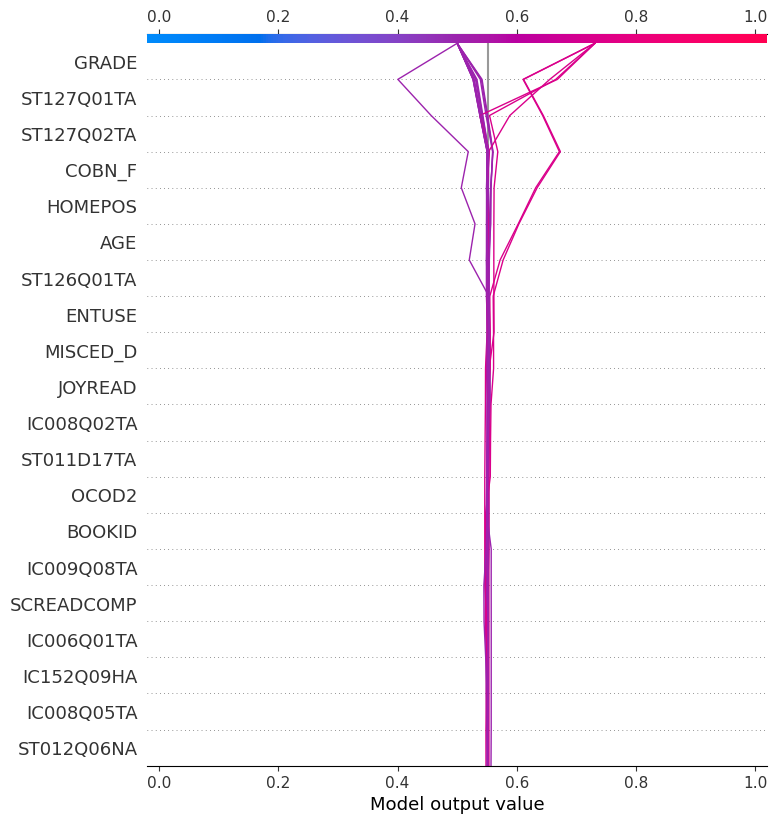

In [36]:
expected_value3 = explainer3.expected_value
features = data.iloc[range(20)]
if isinstance(expected_value3, list):
    expected_value3 = expected_value3[1]
print(f"Explainer expected value: {expected_value3}")

select = range(20)
features = data.iloc[select]
features_display = data.loc[features.index]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer3.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
shap_values32 = explainer3.shap_values(data)[1]

shap.decision_plot(expected_value3[1], shap_values32[1:20], 
                   data.columns,link='logit')



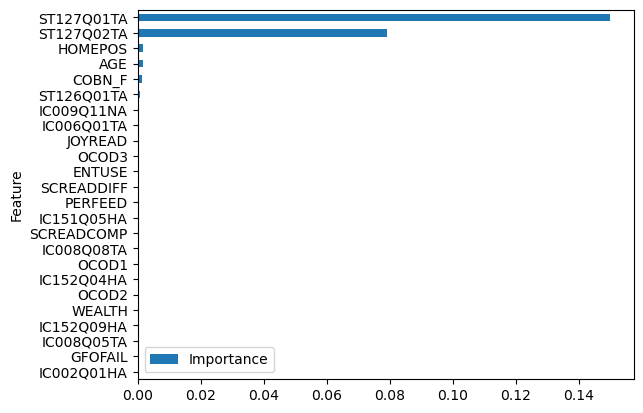

In [37]:
importance_frame = pd.DataFrame({'Importance': list(model3.feature_importances_), 'Feature': data.columns})
importance_frame.sort_values(by='Importance',inplace=True)

importance_frame[-25:-1].plot(kind='barh', x='Feature')
plt.show()


In [38]:
data_new3 = data.loc[:,['ST127Q02TA','ST127Q01TA','GRADE','COBN_F','AGE','HOMEPOS','ENTUSE','IC006Q01TA','STIMREAD']]

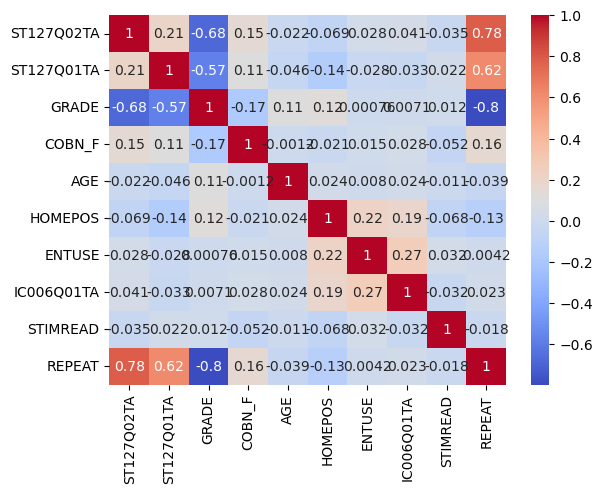

In [39]:
map = draw_corr_map(data_new3)

In [40]:
data_new4 = data.loc[:,['ST127Q02TA','ST127Q01TA','ST001D01T','GRADE','COBN_F','HOMEPOS','ISCEDL','OCOD2']]

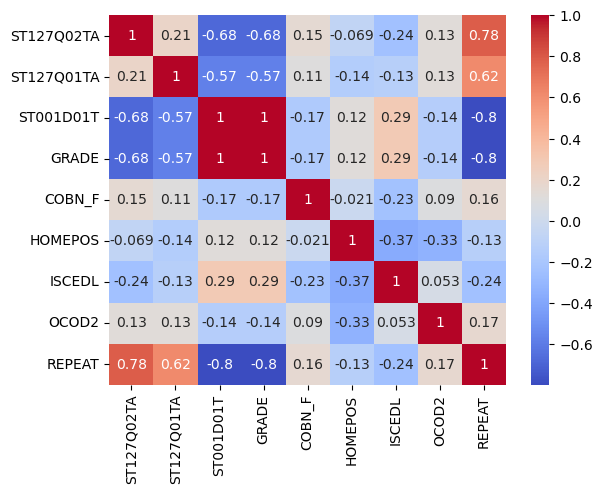

In [41]:
map = draw_corr_map(data_new4)

In [42]:
model4 = XGBClassifier(learning_rate = 0.1,
                            booster = 'gbtree',
                            max_depth = 20,
                            gamma = 2,
                            subsample = 1,
                            objective = 'binary:logitraw',
                            eval_metric = 'mlogloss',)
model.fit(data_new4, labels)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=2, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='binary:logitraw',
              predictor=None, ...)

In [43]:
print(cross_val_score(model4, data_new4, labels,scoring='accuracy', cv=10).mean())

0.9966515308001721


In [44]:
model5 = DecisionTreeClassifier(criterion='gini', max_depth=150)

model5.fit(data_new4, labels)

DecisionTreeClassifier(max_depth=150)

In [45]:
print(cross_val_score(model5, data_new4, labels,scoring='accuracy', cv=10).mean())

0.9929937089322106


In [46]:
data_new4.describe()

,ST127Q02TA,ST127Q01TA,ST001D01T,GRADE,COBN_F,HOMEPOS,ISCEDL,OCOD2
count,42102.000000,42102.000000,42102.000000,42102.000000,42102.000000,42102.000000,42102.000000,42102.000000
mean,1.154675,1.097816,9.748017,-0.251983,163974.450335,-0.364773,2.337751,5922.991687
std,0.383473,0.308881,0.557680,0.557680,292444.079724,1.168049,0.472949,2928.247882
min,1.000000,1.000000,7.000000,-3.000000,15200.000000,-8.942500,2.000000,110.000000
25%,1.000000,1.000000,10.000000,0.000000,48400.000000,-1.019250,2.000000,3153.000000
50%,1.000000,1.000000,10.000000,0.000000,72406.000000,-0.269300,2.000000,6114.000000
75%,1.000000,1.000000,10.000000,0.000000,72413.000000,0.375800,3.000000,8332.000000
max,3.000000,3.000000,12.000000,2.000000,999999.000000,5.429700,3.000000,9999.000000
